In [1]:
import astropy
import croissant as cro
import croissant.jax as crojax
from functools import partial
from healpy import get_nside, projview
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel16 as GSM16
import s2fft

import tools


fatal: No names found, cannot describe anything.


In [2]:
# sim parameters from ForwardSim.ipynb
LMAX = 128
world = "earth"
freq = jnp.arange(50, 101)  # 50-101 MHz
time = astropy.time.Time("2024-10-01 09:00:00")  # time at the beginning of the simulation
loc = astropy.coordinates.EarthLocation(lon=-113, lat=39)  # location of telescope
topo = astropy.coordinates.AltAz(obstime=time, location=loc) # coordinate frame of telescope

ntimes = 240
dt = cro.constants.sidereal_day[world] / ntimes
phases = crojax.simulator.rot_alm_z(LMAX, ntimes, dt, world=world)

# scattering parameters
h = 100  # eigsep height is 100m
c = 2992792458  # m/s
tau = 2*h/c
dly_phase = 2*jnp.pi*(freq[:, None, None]*1e6)*tau  # multiply by 1e6 to get freq in Hz
eps = 1e-3  # coupling coefficient for scattering

# get the euler angles and wigner d functions for the coordinate transforms
eul_topo, dl_topo = crojax.rotations.generate_euler_dl(LMAX, topo, "fk5")  # beam transform, from topocentric to mcmf
eul_gal, dl_gal = crojax.rotations.generate_euler_dl(LMAX, "galactic", "fk5")  # sky transform, from galactic to mcmf

# true beam
theta = s2fft.sampling.s2_samples.thetas(L=LMAX+1, sampling="mwss")
phi = s2fft.sampling.s2_samples.phis_equiang(L=LMAX+1, sampling="mwss")
phi, theta = jnp.meshgrid(phi, theta, sparse=True)
x = jnp.sin(theta) * jnp.cos(phi)
y = jnp.sin(theta) * jnp.sin(phi)
z = jnp.cos(theta)
beamX = (y**2 + z**2) ** (3/2)
beamY = (x**2 + z**2) ** (3/2)
beam = 1/2 * (beamX + beamY)
horizon_mask = jnp.where(theta < jnp.pi/2, 1, 0)  # shape ntheta, 1
# broadcast to ntheta, nphi
horizon_mask *= jnp.ones(phi.size)[None, :]
beam = jnp.repeat(beam[None], freq.size, axis=0)  # achromatic beam for now
horizon_mask = jnp.repeat(horizon_mask[None], freq.size, axis=0)

# true sky
gsm = GSM16(freq_unit="MHz", data_unit="TRJ", resolution="lo")
sky_map = gsm.generate(freq)

# true ground blackbody temperature
T_bb = 300

In [3]:
# coordinate transforms
topo2eq = partial(s2fft.utils.rotation.rotate_flms, L=LMAX+1, rotation=eul_topo, dl_array=dl_topo)
gal2eq = partial(s2fft.utils.rotation.rotate_flms, L=LMAX+1, rotation=eul_gal, dl_array=dl_gal)
# define the map2alm transform for signals sampled with mwss (like beam and horizon)
mwss2alm = partial(s2fft.forward_jax, L=LMAX+1, spin=0, nside=None, sampling="mwss", reality=True)
# define the map2alm transform for signals sampled with healpix
nside = get_nside(sky_map[0])
hp2alm = partial(s2fft.forward_jax, L=LMAX+1, spin=0, nside=nside, sampling="healpix", reality=True)

In [4]:
@jax.jit
def alm_expansions(beam, sky_map, horizon_mask):
    # alm decompositions (see table 1 in the paper)
    alm = jax.vmap(mwss2alm)(beam*horizon_mask)
    blm = jax.vmap(mwss2alm)(beam*(1-horizon_mask))
    clm = jax.vmap(hp2alm)(sky_map)
    dlm = jax.vmap(mwss2alm)(horizon_mask)
    # flm = jax.vmap(hp2alm)(tx_map)
    
    # total power = 2 * sqrt(pi) * a00
    alm_power = crojax.alm.total_power(alm, LMAX)
    blm_power = crojax.alm.total_power(blm, LMAX)
    norm = alm_power + blm_power
    
    # modify dlm like in paper
    dlm *= eps * blm_power[:, None, None]

    return alm, blm, clm, dlm, norm, blm_power

In [17]:
%timeit alm_expansions(beam, sky_map, horizon_mask)

3.86 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
@jax.jit
def forward_sim(beam_model, sky_model):
    alm, blm, clm, dlm, norm, blm_power = alm_expansions(beam, sky_map, horizon_mask)
    # coordinate transforms
    alm = jax.vmap(topo2eq)(alm)
    blm = jax.vmap(topo2eq)(blm)
    clm = jax.vmap(gal2eq)(clm)
    dlm = jax.vmap(topo2eq)(dlm)
    #flm = jax.vmap(topo2eq)(flm)

    T_ant = crojax.simulator.convolve(alm + dlm * jnp.exp(-1j*dly_phase), clm, phases).real
    #T_ant += crojax.simulator.convolve(blm, flm, jnp.ones_like(phases)).real  # tx contribution
    T_ant += blm_power * T_bb
    T_ant /= norm

    return T_ant

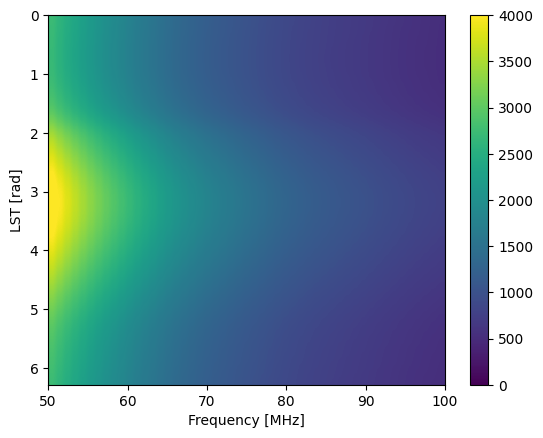

In [6]:
true_T = forward_sim(beam, sky_map)
cmin = 0
cmax = 4000
plt.figure()
im = plt.imshow(true_T, aspect="auto", extent=[freq.min(), freq.max(), 2*jnp.pi, 0])
im.set_clim(cmin, cmax)
plt.colorbar()
plt.ylabel("LST [rad]")
plt.xlabel("Frequency [MHz]")
plt.show()

## Sample over beam and sky!

In [7]:
@jax.jit
def loss(beam_model, sky_model):
    d = true_T - forward_sim(beam_model, sky_model)
    return jnp.sum(d**2)

loss_grad = jax.grad(loss, argnums=(0, 1))

In [8]:
l = loss(beam, sky_map)

In [10]:
g = loss_grad(beam, sky_map)

In [15]:
jnp.allclose(g[1], 0)

Array(True, dtype=bool)

In [17]:
def sgd(beam0, sky0, lr=0.1, N_max=100):
    beam = beam0
    sky = sky0
    beam_vals = jnp.empty((N_max, *beam.shape))
    sky_vals = jnp.empty((N_max, *sky.shape))
    losses = jnp.empty(N_max)
    for cnt in range(N_max):
        print(cnt/N_max)
        l = loss(beam, sky)
        g = loss_grad(beam, sky)
        beam -= lr * g[0]
        sky -= lr * g[0]
        losses = losses.at[cnt].set(l)
        beam_vals = beam_vals.at[cnt].set(beam)
        sky_vals = sky_vals.at[cnt].set(sky)
        if jnp.sum(g**2) < 0.1:
            break
    return beam_vals[:cnt], sky_vals[:cnt], losses[:cnt]

In [ ]:
b, s, l = sgd(beam, sky_map)

0.0
